# Import libraries 

In [1]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Other
import h5py

# Set seed

In [2]:
key = jax.random.PRNGKey(42)

W0000 00:00:1765795370.358441 18483470 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1765795370.397084 18483470 service.cc:145] XLA service 0x7f996f91a860 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765795370.397108 18483470 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1765795370.403023 18483470 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1765795370.403057 18483470 mps_client.cc:384] XLA backend will use up to 22906077184 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



# Set device type

In [3]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
device = gpu if gpu is not None else cpu
jax.default_device(device)
backend = jax.default_backend()

print(backend)

METAL


# Import training data

In [4]:
# Path to the new HDF5 file
file_path = "./data/SIM/simulations_10000_500_S_full.h5"

with h5py.File(file_path, "r") as f:
    # Parameters: load directly as (N,) JAX arrays
    params = {key: jnp.array(f[f"params/{key}"][:]) for key in f["params"].keys()}

    # Data columns: load directly as (N, M) JAX arrays
    data = {col: jnp.array(f[f"data/{col}"][:]) for col in f["data"].keys()}


# Number of simulations and SNe per simulation
N = next(iter(params.values())).shape[0]   # N simulations
M = next(iter(data.values())).shape[1]     # M SNe per simulation

print(f"The file contains {N} simulations of size {M}")

The file contains 10000 simulations of size 500


In [5]:
# Example usage
print("Parameter names:", list(params.keys()))
param_groups = ['mabs', ['alpha', 'beta'], 'gamma'] # Sort them from easiest to hardest to infer
print(param_groups[1])

Parameter names: ['alpha', 'beta', 'gamma', 'mabs']
['alpha', 'beta']


# Compute residuals

In [6]:
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

mu_planck18, data['magobs']= nntr.rm_cosmo(data['z'], data['magobs'], n_grid=10_000)

# Only update 'mabs' if it exists in params
if 'mabs' in params:
    params['mabs'] = params['mabs'] + 19.3

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


## Apply mask

In [7]:
# Masked version (NaNs)
data_filt = {k: jnp.where(mask, v, jnp.nan) for k, v in data.items()}

# Padded version (zeros)
data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}

# Prepare train and test sets

## Set bounds

In [8]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

## Label data

In [9]:
# -----------------------------------------
# Autoregressive dataset construction
# -----------------------------------------

param_names = list(params.keys())
K = len(param_names)  # total number of parameters

# Convert bounds
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

# LHS false parameters
key, lhs_key = jax.random.split(key)
lhs_samples = nntr.lhs_jax(lhs_key, K, N)
false_params = mins + (maxs - mins) * lhs_samples   # (N,K)

# True params in array form
param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)

# ----- Observational data concatenation (unchanged) -----

data_names = list(data_padded.keys())
n_cols = len(data_names)
data_arrays = [data_padded[name] for name in data_names]
data_concat = jnp.concatenate(data_arrays, axis=-1)   # (N, M*n_cols)

## Concatenate data

In [10]:
# ----------------------------------------------------
# Build one dataset per parameter group
# ----------------------------------------------------

all_group_datasets = []  # will contain tuples (inputs_g, outputs_g)

for g, group in enumerate(param_groups):

    # Expand group to list
    group_list = [group] if isinstance(group, str) else group

    # Indices of parameters in this group
    group_idx = jnp.array([param_names.index(name) for name in group_list])

    # Indices of parameters earlier than the group
    prev_groups = [p for i in range(g) for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])]
    prev_idx = jnp.array([param_names.index(name) for name in prev_groups], dtype=int) if len(prev_groups) > 0 else jnp.array([], dtype=int)

    # ------------------------------------------
    # Build mask for current group g
    # ------------------------------------------
    key, label_key = jax.random.split(key)
    labels = jax.random.uniform(label_key, (N,)) > 0.5  # True = use true params, False = use false

    # Copy arrays
    params_group = jnp.array(param_true)

    # previous groups: set to true
    if prev_idx.size > 0:
        params_group = params_group.at[:, prev_idx].set(param_true[:, prev_idx])

    # current group: masked true/false
    chosen = jnp.where(labels[:, None], param_true[:, group_idx], false_params[:, group_idx])
    params_group = params_group.at[:, group_idx].set(chosen)

    # ------------------------------------------
    # Build NN inputs for this group
    # Only include data + previous + current parameters
    # ------------------------------------------
    visible_idx = jnp.concatenate([prev_idx, group_idx], axis=0) if prev_idx.size > 0 else group_idx
    params_visible = params_group[:, visible_idx]

    inputs_g = jnp.concatenate([data_concat, mask, params_visible], axis=-1)

    # Single label per sample
    outputs_g = labels.astype(jnp.int32)[:, None]  # shape (N,1)

    all_group_datasets.append((inputs_g, outputs_g))



# Build a neural network

In [11]:
class Embedding(nnx.Module):
    """
    Neural network module for parameters embedding
    """
    def __init__(self, N_size_embed, n_params, *, rngs):
        self.linear1 = nnx.Linear(n_params, N_size_embed*2, rngs=rngs)
        self.linear2 = nnx.Linear(N_size_embed*2, N_size_embed*2, rngs=rngs)
        self.linear3 = nnx.Linear(N_size_embed*2, N_size_embed, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        return x


class Phi(nnx.Module):
    """
    Neural network module for the Phi network in a Deep Set architecture.
    """
    def __init__(self, Nsize, n_cols, n_params, *, rngs):
        # LayerNorm on full concatenated input (pooled + embed)
        self.norm_input = nnx.LayerNorm(n_cols+n_params, rngs=rngs)

        self.linear1 = nnx.Linear(n_cols+n_params, Nsize, rngs=rngs)
        self.linear2 = nnx.Linear(Nsize, Nsize, rngs=rngs)
        self.linear3 = nnx.Linear(Nsize, Nsize, rngs=rngs)

    def __call__(self, data, params):
        h = jnp.concatenate([data,params], axis=-1)
        # Apply LayerNorm on full input
        # h = self.norm_input(h)
        
        h = nnx.relu(self.linear1(h))
        h = nnx.relu(self.linear2(h))
        h = nnx.relu(self.linear3(h))
        return h


class Rho(nnx.Module):
    """
    Neural network module for the Rho network in a Deep Set architecture
    with separate LayerNorm for pooled features and theta.
    """
    def __init__(self, Nsize_p, Nsize_r, N_size_embed, *, rngs):
        # LayerNorm on full concatenated input (pooled + embed)
        self.norm_input = nnx.LayerNorm(Nsize_p + N_size_embed + 1, rngs=rngs)

        self.linear1 = nnx.Linear(Nsize_p + N_size_embed + 1, Nsize_r, rngs=rngs)
        self.linear2 = nnx.Linear(Nsize_r, Nsize_r, rngs=rngs)
        self.linear3 = nnx.Linear(Nsize_r, 1, rngs=rngs)

    def __call__(self, dropout, pooled_features, embed):
        # Concatenate pooled features and embedding
        x = jnp.concatenate([pooled_features, embed], axis=-1)

        # Apply LayerNorm on full input
        # x = self.norm_input(x)

        x = nnx.relu(self.linear1(x))
        x = dropout(x)

        x = nnx.relu(self.linear2(x))
        x = dropout(x)

        return self.linear3(x)


class DeepSetClassifier(nnx.Module):
    """
    Deep Set Classifier model combining Phi and Rho networks.
    """
    def __init__(self, dropout_rate, Nsize_p, Nsize_r, N_size_embed,
                 n_cols, n_params, *, rngs):

        self.dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        self.n_cols   = n_cols
        self.n_params = n_params

        self.phi = Phi(Nsize_p, n_cols, n_params, rngs=rngs)
        self.rho = Rho(Nsize_p, Nsize_r, N_size_embed, rngs=rngs)
        self.embed = Embedding(N_size_embed, n_params, rngs=rngs)

    def __call__(self, input_data):
        # ----------------------------------------------------
        # Accept both shape (N, D) and (D,) without failing
        # ----------------------------------------------------
        if input_data.ndim == 1:
            input_data = input_data[None, :]

        N = input_data.shape[0]
        input_dim = input_data.shape[1]

        # Compute M first from input size
        # Total input columns = M*n_cols + n_params + M (mask)
        M = (input_dim - self.n_params) // (self.n_cols + 1)

        # Reshape data columns
        data = input_data[:, :M*self.n_cols].reshape(N, M, self.n_cols)

        # Slice mask (last M columns)
        mask = input_data[:, -M-self.n_params:-self.n_params]         # shape (N, M)

        # Parameters
        theta = input_data[:, -self.n_params:]  # shape (N, n_params)

        # Expand params to (N, M, n_params)
        params_expanded = jnp.expand_dims(theta, axis=1)  # (N, 1, n_params)
        params_expanded = jnp.tile(params_expanded, (1, M, 1))  # (N, M, n_params)

        # Apply Phi
        h = self.phi(data, params_expanded)

        # Apply mask
        h_masked = h * mask[..., None]

        # Pool (masked average)
        mask_sum = jnp.sum(mask, axis=1, keepdims=True)
        mask_sum = jnp.where(mask_sum == 0, 1.0, mask_sum)
        pooled = jnp.sum(h_masked, axis=1) / mask_sum # Try jnp.sqrt(mask_sum) ?

        pooled_N = jnp.concatenate([pooled, mask_sum], axis=-1)

        embed = self.embed(theta)

        # Apply Rho
        return self.rho(self.dropout, pooled_N, embed)

In [12]:
# Define the size of the different network layers
N_size_embed = 32 #32
Nsize_p = 128 #128
Nsize_r = 256 #256

n_cols = len(data_names)
print('# of columns :', n_cols)
n_params = len(param_names)
print('# of params :', n_params)


# of columns : 10
# of params : 4


In [13]:
# ----------------------------
# Prepare a list of models, one per group
# ----------------------------

models_per_group = []
group_configs = []
rng = nnx.Rngs(0)

for g, group in enumerate(param_groups):
    # Determine number of parameters visible for this group
    prev_groups = [
        p
        for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    group_list = [group] if isinstance(group, str) else group
    visible_param_names = prev_groups + group_list
    n_params_visible = len(visible_param_names)

    print(
        f"Group {g}: visible parameters = {visible_param_names}, "
        f"total = {n_params_visible}"
    )

    # Create DeepSetClassifier for this group
    model_g = DeepSetClassifier(
        dropout_rate=0.1,
        Nsize_p=Nsize_p,
        Nsize_r=Nsize_r,
        N_size_embed=N_size_embed,
        n_cols=n_cols,
        n_params=n_params_visible,
        rngs=rng,
    )

    models_per_group.append(model_g)

    # ---- CONFIG CAPTURE (THIS IS THE KEY ADDITION) ----
    group_configs.append({
        "group_id": g,
        "n_params_visible": n_params_visible,
        "visible_param_names": visible_param_names,
    })


model_config = {
    "shared": {
        "Nsize_p": Nsize_p,
        "Nsize_r": Nsize_r,
        "N_size_embed": N_size_embed,
        "n_cols": n_cols,
    },
    "groups": group_configs,
}

# Optional: visualize one model
nnx.display(models_per_group[0])


Group 0: visible parameters = ['mabs'], total = 1
Group 1: visible parameters = ['mabs', 'alpha', 'beta'], total = 3
Group 2: visible parameters = ['mabs', 'alpha', 'beta', 'gamma'], total = 4


In [14]:
# Define the learning rate schedule 
learning_rate_schedule = optax.exponential_decay(
    init_value=5e-4,
    transition_steps=1000,  # Decay every 1000 forward passes
    decay_rate=0.9,
)

momentum = 0.9 # Necessary for the Adam optimiser

# Train NN

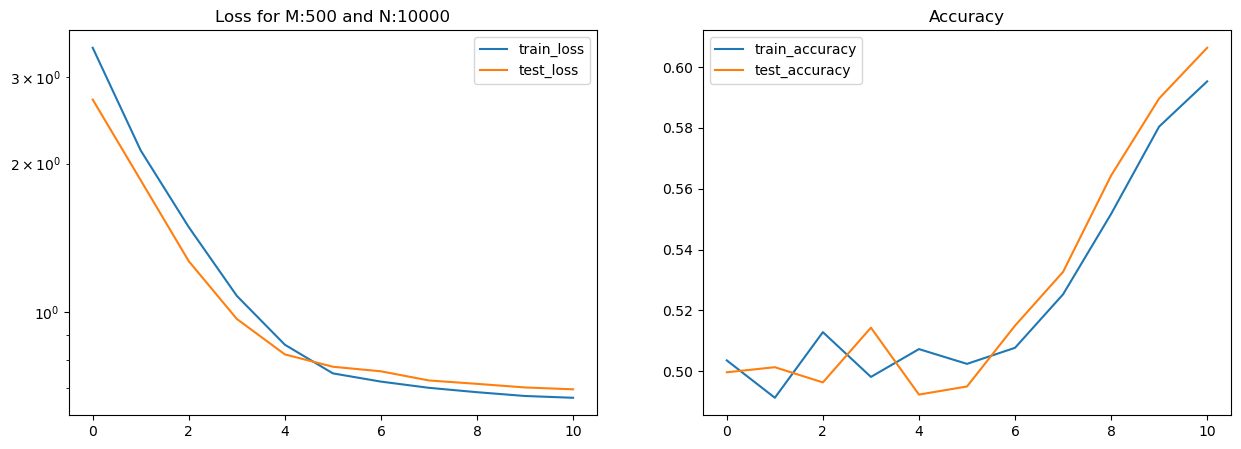

KeyboardInterrupt: 

In [15]:
# Early stopping parameters
n_batch = 40
patience = 30 # Number of epochs to wait for improvement
epochs = 1000 # Maximum number of epochs
# all_group_datasets is a list of (inputs_g, outputs_g)
metrics_histories = []

for g, (inputs_g, outputs_g) in enumerate(all_group_datasets):
    
    print(f"\n=== Training model for group {g}: {param_groups[g]} ===")

    inputs_g_cpu = jax.device_put(inputs_g, cpu)
    outputs_g_cpu = jax.device_put(outputs_g, cpu)

    # Split train/test
    key, split_key = jax.random.split(key)
    train_data, test_data, train_labels, test_labels = nntr.train_test_split_jax(
        inputs_g, outputs_g, test_size=0.3, shuffle=True, key=split_key
    )

    # Initialize metrics history
    metrics_history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

    # Initialize optimizer (one per model)
    optimizer = nnx.Optimizer(models_per_group[g], optax.adamw(learning_rate_schedule, momentum))

    # Compute batch size
    batch_size = train_data.shape[0] // n_batch

    # Train loop
    model_g, metrics_history, key = nntr.train_loop(
        model=models_per_group[g],
        optimizer=optimizer,
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        key=key,
        epochs=epochs,
        batch_size=batch_size,
        patience=patience,
        metrics_history=metrics_history,
        M=M,
        N=N,
        cpu=cpu,
        gpu=gpu,
        plot_flag=True  # or False
    )

    # Save trained model back
    models_per_group[g] = model_g
    metrics_histories.append(metrics_history)


# Test NN

## Test Accuracy

In [18]:
import jax.scipy as jsp

# Set models to evaluation mode
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

batch_size = 128
num_samples = test_data.shape[0]

# Initialize storage for metrics per group
metrics_per_group = []

# Loop over groups (autoregressive)
for g, model_g in enumerate(models_per_group):
    
    # Get corresponding test inputs and labels for this group
    inputs_g, labels_g = all_group_datasets[g]
    
    # Optional: use only test subset if you did train/test split
    # Here assume test_data and test_labels from earlier splitting
    # Or slice inputs_g[test_idx] if you kept indices
    
    all_logits = []
    all_labels = []

    for i in range(0, num_samples, batch_size):
        xb = inputs_g[i : i + batch_size]
        yb = labels_g[i : i + batch_size]

        # logits from model
        logits = nntr.pred_step(model_g, xb)
        all_logits.append(logits)
        all_labels.append(yb > 0.5)

    # Merge batches
    all_logits = jnp.concatenate(all_logits, axis=0)
    all_preds  = jsp.special.expit(all_logits) > 0.5
    all_labels = jnp.concatenate(all_labels, axis=0)

    # Compute standard metrics
    TP = jnp.sum((all_preds == 1) & (all_labels == 1))
    TN = jnp.sum((all_preds == 0) & (all_labels == 0))
    FP = jnp.sum((all_preds == 1) & (all_labels == 0))
    FN = jnp.sum((all_preds == 0) & (all_labels == 1))

    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    precision   = TP / (TP + FP + 1e-8)
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    print(f"Group {g} ({param_groups[g]}): Accuracy={accuracy:.3f}, Precision={precision:.3f}, "
          f"Sensitivity={sensitivity:.3f}, Specificity={specificity:.3f}")

    metrics_per_group.append({
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity
    })


Group 0 (mabs): Accuracy=0.494, Precision=0.494, Sensitivity=1.000, Specificity=0.000
Group 1 (['alpha', 'beta']): Accuracy=0.497, Precision=0.497, Sensitivity=0.999, Specificity=0.001
Group 2 (gamma): Accuracy=0.506, Precision=0.506, Sensitivity=1.000, Specificity=0.000


## Test TARP

In [32]:
# ----------------------------
# Set all models to evaluation mode
# ----------------------------
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

# ----------------------------
# Parameter info
# ----------------------------
param_names = list(bounds.keys())
NDIM = len(param_names)
BOUNDS = jnp.array([[bounds[name]['min'], bounds[name]['max']] for name in param_names])

# ----------------------------
# Select "true" parameter samples from the first group
# ----------------------------
inputs_first_group, outputs_first_group = all_group_datasets[-1]
mask_true = outputs_first_group[:, 0] == 1  # only samples where label == 1
N_sims = int(jnp.minimum(100, jnp.sum(mask_true)))

# Extract test inputs and full theta for MCMC/TARP
xy_test = inputs_first_group[mask_true, :][:N_sims, :]
theta_star = inputs_first_group[mask_true, -NDIM:][:N_sims, :]


In [33]:
alpha_grid = jnp.linspace(0, 1, 50)

if backend == "METAL":
    # METAL GPU branch
    print("Launching MCMC (JIT‐compiled) on METAL GPU...")
    with jax.default_device(cpu):
        ecp_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_with_progress_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, param_names, batch_size=20
        )   
    print("MCMC finished on METAL")

elif backend == "cuda":
    # CUDA GPU branch
    print("Launching MCMC (JIT‐compiled) on CUDA GPU...")
    with jax.default_device(cpu):
        ecp_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, param_names, batch_size=20
        )   
    print("MCMC finished on CUDA")

else:
    # CPU fallback
    print("Launching MCMC (JIT‐compiled) on CPU...")
    with jax.default_device(cpu):
        ecp_vals, posterior_uns, key = nnte.compute_ecp_tarp_jitted_with_progress_groups(
            models_per_group, xy_test, theta_star, alpha_grid, 100, 100, key, BOUNDS,
            param_groups, param_names, batch_size=20
        )   
    print("MCMC finished on CPU")

Launching MCMC (JIT‐compiled) on METAL GPU...


Computing ECP batches:   0%|          | 0/5 [00:00<?, ?it/s]

MCMC finished on METAL


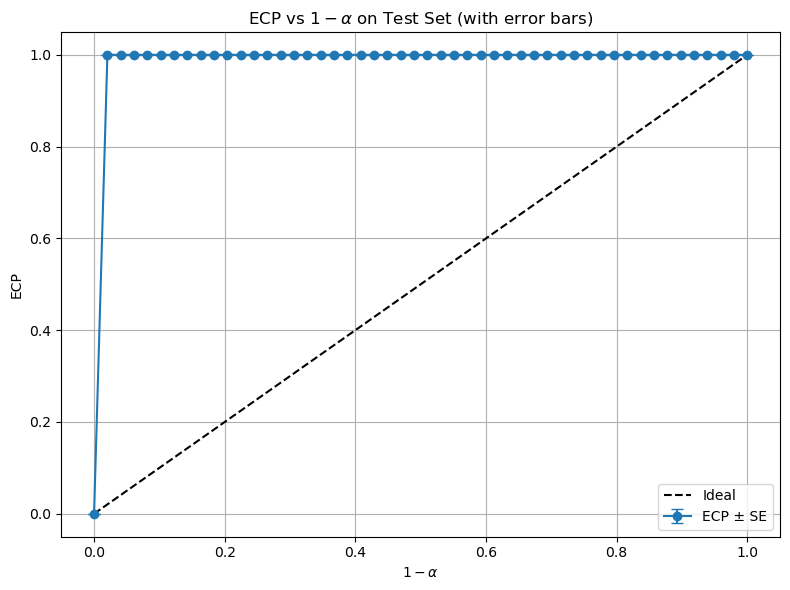

In [35]:
# Example: 1 - alpha grid and computed ecp
alpha_grid = jnp.array(alpha_grid)
ecp = jnp.array(ecp_vals)

# Compute standard error for binomial proportion
se = jnp.sqrt(ecp * (1 - ecp) / N_sims) #https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wald_interval

# CHECK HOW TO COMPUTE THE ERROR

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(1 - alpha_grid, ecp, yerr=se, fmt='o-', capsize=4, label='ECP ± SE')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal')
plt.xlabel(r'$1 - \alpha$')
plt.ylabel("ECP")
plt.title("ECP vs $1 - \\alpha$ on Test Set (with error bars)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Test posterior

In [36]:
print(theta_star[1,:])

[1. 1. 1. 1.]


In [37]:
# Select a single test sample (or batch) as input
test_data = xy_test[0, :]  # single sample, shape (n_features,)

with jax.default_device(cpu):
    def log_post(theta):
        # Use the new grouped log-prob function
        return nnte.log_prob_fn_groups(
            theta,
            models_per_group,  # list of models per group
            test_data,
            BOUNDS,
            param_groups,
            param_names
        )

    # Initial position at the middle of priors
    theta_init = (BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0

    print("Launch MCMC ...")
    # Run MCMC
    key, post = nnte.sample_posterior(
        log_post,
        n_warmup=1000,
        n_samples=1000,
        init_position=theta_init,
        rng_key=key
    )

print("...finished")


Launch MCMC ...
...finished


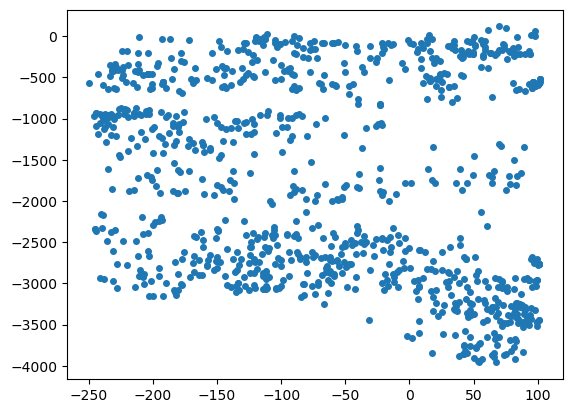

In [38]:
plt.plot(post[:,3], post[:,1], 'o', markersize=4)  # faster than scatter ??
plt.show()

# Save NN to disk

In [ ]:
# # Save the trained model for future use
# nntr.save_nn(model,'../data/NNs/nn_model', model_config)